### Dataset preparation

In [9]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from neuralsens import partial_derivatives as ns

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT

In [10]:
df = pd.read_csv('fico.csv')
# Pasar la variable RiskPerformance a int64
df['RiskPerformance'] = df['RiskPerformance'].astype('int64')
# Put the column RiskPerformance as a category
df['RiskPerformance'] = df['RiskPerformance'].astype('category')
# Change RiskPerformance values, if they are 1 to True and if they are 0 to False
df['RiskPerformance'] = df['RiskPerformance'].replace({1: 'Yes', 0: 'No'})
df.dropna(inplace=True)
# Drop the column called NumTotalTrades
df.drop(columns='NumTotalTrades', inplace=True)

In [11]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance',
       'PercentInstallTrades', 'NumSatisfactoryTrades', 'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
OUTPUT = 'RiskPerformance'

X = df[INPUTS]
Y = df[OUTPUT]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2023, #seed for replication
                                                    stratify = Y)   #Preserves distribution of y. Same proportion. useful for classification but not for regression problemas

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity

### Training of MLP model

In [12]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP = INPUTS

param = {'MLP__alpha': [1e-9,1e-7,1e-5,0.001,0.01], # L2 regularization term. Landa, weight decay
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples
#param = {'MLP__alpha': [0], # L2 regularization term. Landa, weight decay
#         'MLP__hidden_layer_sizes':[(3,2)]} # Number of neurons in each hidden layer, enters as tuples. Solo 1 capa oculta, las combinaciones 
# que quiero probar son 3 y 2 neuronas en cada capa oculta

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function. Other options: ‘sgd’, ‘adam’
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization. If from one epoch to the next, the improvement is less than tol, stop
                                             random_state=150, # Seed for replication
                                             verbose = True))]) # For printing progress messages

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], Y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('MLP',
                                        MLPClassifier(activation='logistic',
                                                      max_iter=450,
                                                      random_state=150,
                                                      solver='lbfgs',
                                                      verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [1e-09, 1e-07, 1e-05, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(5,), (10,), (15,), (20,),
                                                     (25,)]},
             scoring='accuracy')

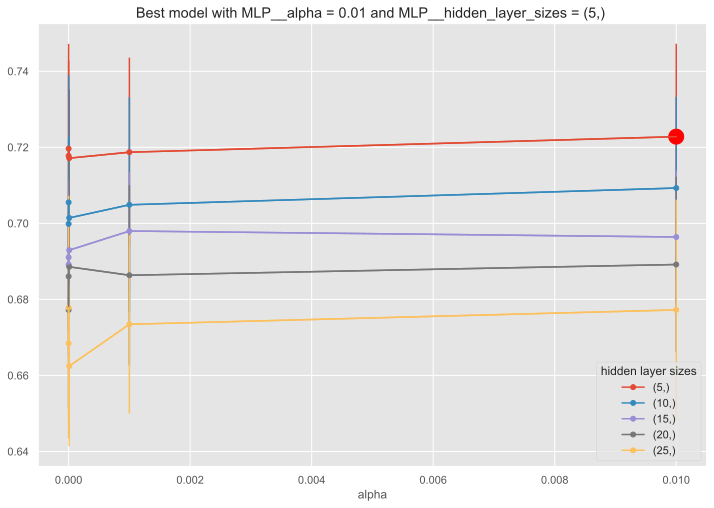

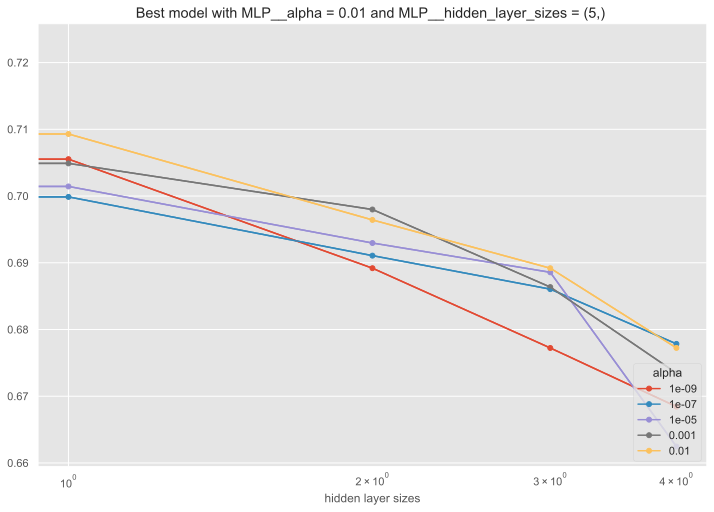

In [13]:
MT.plotModelGridError(MLP_fit, xscale2="log")

In [14]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(Y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [15]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [16]:
sensmlp.summary()

Sensitivity analysis of [9, 5, 1] MLP network.

Sensitivity measures of each output:

$ExternalRiskEstimate 

                                  mean       std  mean_squared
ExternalRiskEstimate         -0.099690  0.105807      0.145373
NetFractionRevolvingBurden    0.052636  0.085765      0.100629
AverageMInFile               -0.085885  0.097195      0.129704
MSinceOldestTradeOpen         0.020091  0.042889      0.047361
PercentTradesWBalance         0.014948  0.055095      0.057087
PercentInstallTrades          0.014584  0.054736      0.056646
NumSatisfactoryTrades        -0.045406  0.143847      0.150843
PercentTradesNeverDelq       -0.089885  0.143540      0.169361
MSinceMostRecentInqexcl7days -0.287821  0.270871      0.395236


In [17]:
sensmlp.info()

Sensitivity analysis of [9, 5, 1] MLP network.

3182 samples

Sensitivities of each output (only 5 first samples):

$ExternalRiskEstimate 

   ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
0             -0.065755                    0.066867       -0.053250   
1             -0.045402                    0.039556       -0.052290   
2             -0.090966                    0.062793       -0.104519   
3             -0.030400                    0.022554       -0.036263   
4             -0.047969                   -0.010491       -0.058701   

   MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
0               0.000245               0.002064             -0.003771   
1               0.018782               0.005958             -0.012807   
2               0.005582               0.022251             -0.020945   
3               0.012374               0.006587             -0.009253   
4              -0.013580               0.027950              0.00480

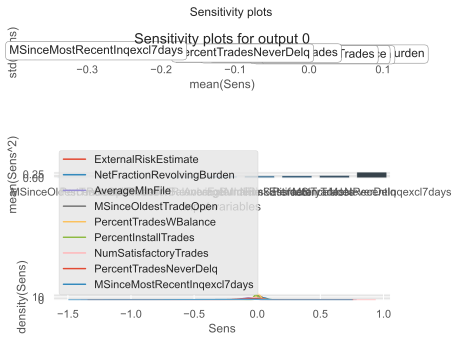

In [18]:
sensmlp.plot()
## Make this plot bigger, because I cannot see anything


In [19]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_MLP_pred,Y_MLP_prob_neg,Y_MLP_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,93.0,3.0,No,No,0.748003,0.251997
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,100.0,0.0,No,No,0.760106,0.239894
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,100.0,2.0,No,Yes,0.499204,0.500796
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,100.0,0.0,Yes,Yes,0.192653,0.807347
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,86.0,12.0,Yes,Yes,0.187654,0.812346


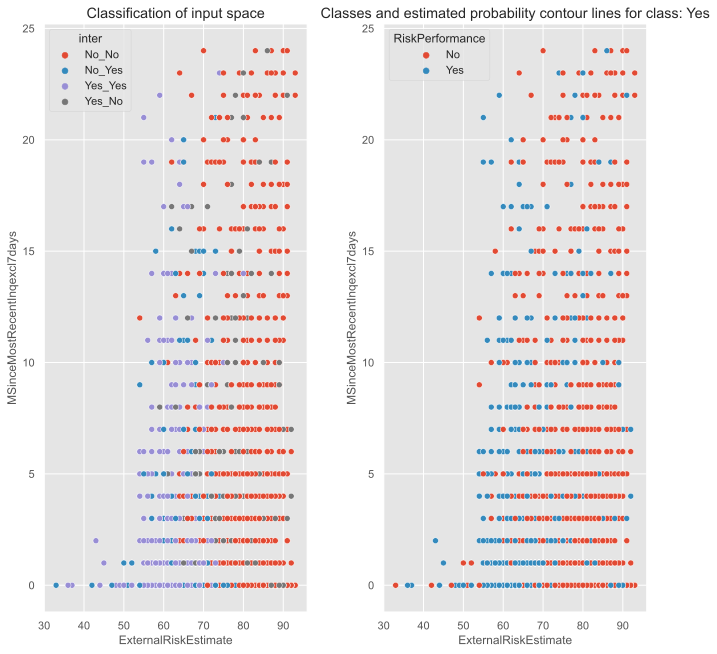

In [20]:
### Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 10))
CT.plot2DClass(X_train[INPUTS_MLP], dfTR_eval['RiskPerformance'], MLP_fit, 'ExternalRiskEstimate', 'MSinceMostRecentInqexcl7days', 'Yes', 50) 

In [21]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_MLP_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference   No  Yes
       No 1137  420
      Yes  399 1226

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.48
Sensitivity: 0.75
Specificity: 0.73
Precision: 0.74
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.74
Positive label: No


In [22]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_MLP_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference  No  Yes
       No 291   99
      Yes  95  311

Accuracy: 0.76
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.51
Mcnemar's Test P-Value: 0.83
Sensitivity: 0.77
Specificity: 0.75
Precision: 0.75
Recall: 0.75
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.76
F1 Score: 0.75
Positive label: No


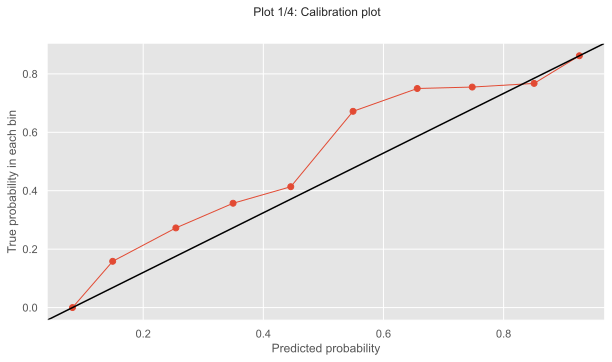

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


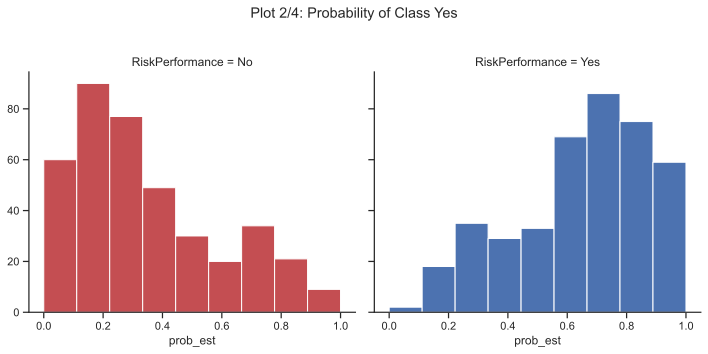

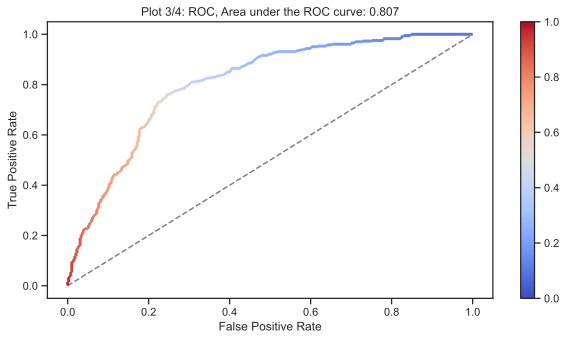

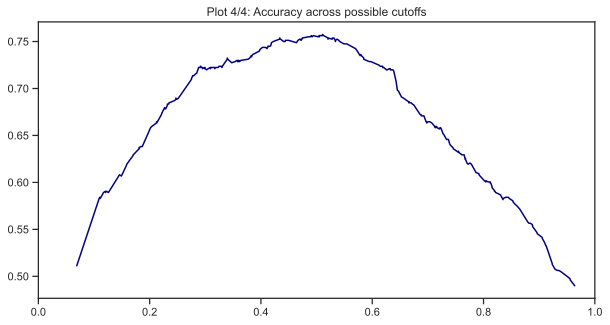

In [23]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass='Yes')